This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import pickle

from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/IPUMS/non_normalized_cleaned_ipums_data.csv")

In [3]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,11000,16.000000,18.000000,0,1
1,38000,15.000000,23.000000,0,0
2,7000,13.000000,2.000000,0,0
3,2600,11.000000,0.000000,0,0
4,20800,12.000000,33.000000,1,0
...,...,...,...,...,...
197751,22500,16.000000,13.000000,0,0
197752,4500,16.000000,11.000000,0,1
197753,37000,17.737673,19.262327,0,0
197754,1500,15.000000,13.000000,0,1


***

# Full Sequential Synthesis Driven by Bayesian Optimization

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [8]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_non_white_,
                 mb_sex_):
    
    num_samples = train_data.shape[0]

    # create normalized version of training data 'continuous variables'
    # normalizer = preprocessing.StandardScaler().fit(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    # norm_train = normalizer.transform(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']])

    # new_train = train_data.copy()
    # new_train['incwage'] = np.log(new_train['incwage'])
    # new_train['years_of_educ'] = np.log(new_train['years_of_educ'] + 1)
    # new_train['potential_experience'] = np.log(new_train['potential_experience'] + 1)
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(train_data.loc[:,["incwage", "years_of_educ", "potential_experience"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        # sX = normalizer.inverse_transform(sX)
        sX = pd.DataFrame(sX)
        sX.columns = ['incwage', 'years_of_educ', 'potential_experience']
        # sX.loc[:,'incwage'] = np.where(sX.incwage < 1, 1, sX.incwage)
        # sX[['incwage', 'years_of_educ', 'potential_experience']] = np.exp(sX[['incwage', 'years_of_educ', 'potential_experience']])
        # sX['years_of_educ'] = sX['years_of_educ'] - 1
        # sX['potential_experience'] = sX['potential_experience'] - 1
        sXs.append(sX)

    ####################################################################################################
        
    ####################################################################################################
        
    ########### Code for non_white CART ##########
    cart_non_white = DecisionTreeClassifier(min_samples_leaf=mb_non_white_, random_state=rng)
    
    cart_non_white.fit(X=train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']], y=train_data.loc[:,"non_white"])
    
    node_indicators = cart_non_white.decision_path(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']]).toarray()
    
    node_outcomes = [train_data['non_white'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_non_white.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        
        new_non_white = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_non_white[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_non_white = pd.Series(new_non_white)
        
        new_non_white.name = "non_white"
        
        sXs[i] = pd.concat([sXs[i], new_non_white], axis=1)
    
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [9]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_non_white_, mb_sex_):

        pmse_ratios, _, _ = train_models(train_data=train_data,
                                         number_synthetic_datasets=number_synthetic_datasets,
                                         number_gmm_initializations=number_gmm_initializations,
                                         num_components_=int(num_components_),
                                         mb_non_white_=int(mb_non_white_),
                                         mb_sex_=int(mb_sex_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_non_white_": (10, 300.99),
            "mb_sex_": (10, 300.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [10]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [11]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | mb_non... |  mb_sex_  | num_co... |
-------------------------------------------------------------
| 1         | -1.395e+0 | 226.2     | 75.89     | 132.7     |
| 2         | -9.093e+0 | 266.8     | 225.5     | 147.8     |
| 3         | -8.626e+0 | 95.94     | 162.9     | 43.19     |
| 4         | -5.563e+0 | 246.3     | 257.2     | 58.99     |
| 5         | -3.146e+0 | 79.03     | 143.4     | 53.72     |
| 6         | -8.945e+0 | 244.6     | 253.5     | 56.68     |
| 7         | -6.863e+0 | 265.9     | 90.63     | 89.69     |
| 8         | -1.357e+0 | 106.7     | 135.1     | 79.31     |
| 9         | -9.432e+0 | 237.1     | 83.32     | 175.2     |
| 10        | -7.307e+0 | 213.2     | 284.8     | 115.6     |
| 11        | -6.65e+03 | 107.8     | 207.2     | 63.04     |
| 12        | -9.481e+0 | 97.65     | 205.1     | 105.3     |
| 13        | -1.306e+0 | 15.26     | 28.32     | 169.8     |
| 14        | -1.096e+0 | 63.88     | 61.93     | 180.7     |
| 15    

KeyboardInterrupt: 

***

In [8]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

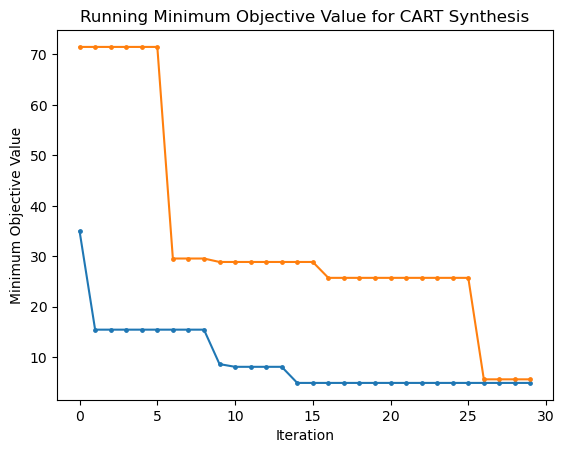

In [9]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [10]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [11]:
best_params

{'target': -4.910662782244686,
 'params': {'mb_non_white_': 227.12623619508477,
  'mb_sex_': 72.64635196934162,
  'num_components_': 135.59024050082118}}

***

Generate 20 synthetic datasets.

In [12]:
pmse_ratios, full_sXs, GMM = train_models(train_data=train_data,
                                          number_synthetic_datasets=20,
                                          # hyperparameters for GMM
                                          number_gmm_initializations=ngi,
                                          num_components_=int(best_params['params']['num_components_']),
                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                          mb_non_white_=int(best_params['params']['mb_non_white_']))

In [13]:
np.mean(pmse_ratios)

5.367789921824238

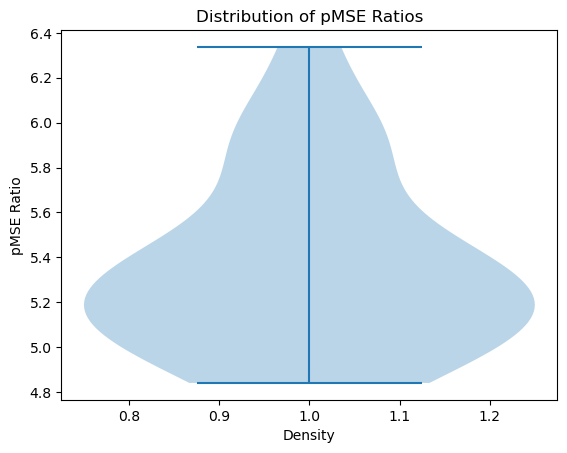

In [14]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

In [15]:
full_sXs[0]

,incwage,years_of_educ,potential_experience,non_white,sex
0,33291.916059,14.999722,12.563422,0,0
1,33516.858068,15.001655,14.003966,1,0
2,36094.916241,14.998224,16.780492,0,1
3,33691.723997,15.001497,18.846409,0,0
4,80936.039425,14.999947,14.297163,0,0
...,...,...,...,...,...
197751,53054.935107,17.737271,38.064317,0,0
197752,29795.253782,17.738005,35.731274,0,1
197753,38750.940337,17.737468,28.417546,0,1
197754,44394.927082,17.736236,35.488096,0,0


# Save the synthetic datasets.

In [24]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/non_normalized_gmm_and_cart_" + str(i) + ".csv", index=False)

# save
with open('../Results/IPUMS/Models/non_normalized_gmm_and_cart.pkl','wb') as f:
    pickle.dump(GMM,f)

***

In [ ]:
full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/non_normalized_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

In [ ]:
# load
with open('../Results/IPUMS/Models/non_normalized_gmm_and_cart.pkl', 'rb') as f:
    GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [4]:
prior = np.mean(train_data.non_white == 1)

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [5]:
prior

0.14195270939946197

In [ ]:
c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [ ]:
deltas = np.linspace(0.001, 0.1, 3)

In [ ]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                         categorical_vars=['sex'],
                                         sensitive_var='non_white',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

In [ ]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)

***